## Welcome to the basic neural network tutorial!
The following notebook is designed to walk through the process of building and training your first scikit based algorithm using the standalone MaCh3 python utilities!

If you're writing scripts this is encapsulate in the objects in `MaCh3PythonUtils/config_reader` however this guide aims to break apart the process of writing the code for yourself!

The first step is to load in a MaCh3 MCMC fit as input file. This is done using the ChainHandler class!

In [ ]:
# MaCh3Python Deps
from MaCh3PythonUtils.file_handling.chain_handler import ChainHandler
from MaCh3PythonUtils.machine_learning.ml_factory import MLFactory

# Other imports
from matplotlib import pyplot as plt
from pathlib import Path
import gdown

In [ ]:
# Download file from google drive

file_url="https://drive.google.com/file/d/1iE6xFhn3BH_HnLUfQ7KFGy2wfeH52Rwf/view?usp=sharing"

# download the file
input_file = Path("../models/demo_chain.root")

if not input_file.exists():
    # download the file
    input_file.parent.mkdir(parents=True, exist_ok=True)
    gdown.download(file_url, str(input_file), quiet=False, fuzzy=True)


In [ ]:
# Set up file properties
chain_name = 'posteriors'
verbose=False

chain_handler = ChainHandler(str(input_file), chain_name, verbose=verbose)

Attempting to open ../models/demo_chain.root
Succesfully opened ../models/demo_chain.root:posteriors


Okay, now we've loaded in a file we need to do a bit of processing. This means we need to select the variables we care about and apply parameter cuts

In [ ]:
# Firstly we set things we want to ignore, these are parameters we really don't care about/want to learn!
chain_handler.ignore_plots(["LogL_systematic_xsec_cov", "Log", "LogL_systematic_osc_cov"])

# Now we add parameters we care about. Note this only need to be a substring of the full name
chain_handler.add_additional_plots(["sin2th", "delm2", "delta", "xsec"])

# The fitting label is special, it's the thing we want to train our network to predict
fitting_label = "LogL"
# We need to make sure the chain handler knows this exists, passing true means it is looking for some with that exact name
chain_handler.add_additional_plots(fitting_label, True)

# Finally we can do some cuts to get rid of things like burn-in
chain_handler.add_new_cuts(["LogL<30", "LogL_systematic_xsec_cov<1234", "step>10000"])

# Last step is convert the chain into a pandas dataframe
chain_handler.convert_ttree_to_array()

Let's quickly use the chain handler to make a plot of the trace and posterior!

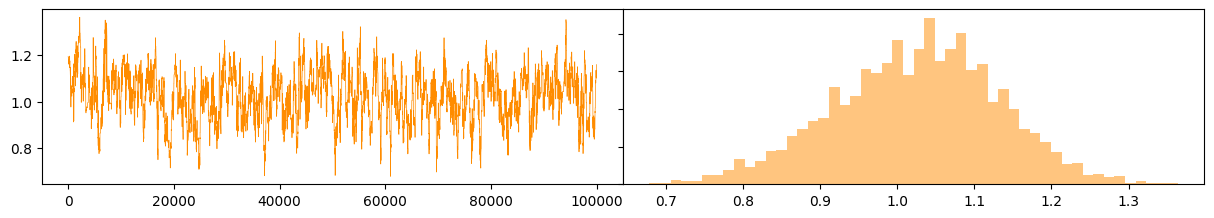

In [ ]:
from MaCh3PythonUtils.file_handling.chain_diagnostics import ChainDiagnostics
plotter=ChainDiagnostics(chain_handler)

plotter("xsec_0")
plt.show()


## Machine learning
Okay now we've done some very basic file manipulation, it's time for some machine learning!
All algorithms use the same common `MLFactory` interface so let's go about configuring it!

In [ ]:
# First step we need to initialise the factory
from pathlib import Path


model_output=Path("../models/my_model")
# Make sure the model output directory exists
model_output.parent.mkdir(parents=True, exist_ok=True)

# The factory produces ML models, we need to pass it the chain handler and the fitting label to get started
ml_factory = MLFactory(chain_handler, fitting_label, f"{model_output}.pdf")

Now we need to define a model, for this demonstration we'll make a very simple BDT!

In [ ]:
# We now want the actual neural network properties
# Usually you set this using a YAML file (see configs for some examples) but we'll do this manually for now
build_settings = {
    # Loss function
    'loss': 'mse',
    # Metrics to measure
    'metrics': ['mae', 'mse'],
    # Learning rate
    'learning_rate': 0.001,
}

# Settings used when the model is fitting
fit_settings = {
    'batch_size': 4096,
    'epochs': 100,
    'validation_split': 0.2,
}

In [ ]:
# Now we can make the model
ml_model = ml_factory.make_interface('SciKit', 'histboost', loss='absolute_error', max_iter=10000, verbose=2, max_leaf_nodes=400, learning_rate=0.01)

# Let's use 20% of the data for testing
ml_model.set_training_test_set(0.2)

In [ ]:
# Now we need to train our network
ml_model.train_model()

Training Model
Binning 0.017 GB of training data: 0.088 s
Binning 0.002 GB of validation data: 0.006 s
Fitting gradient boosted rounds:
[1/10000] 1 tree, 400 leaves, max depth = 33, train loss: 2.66150, val loss: 2.67616, in 0.293s
[2/10000] 1 tree, 400 leaves, max depth = 33, train loss: 2.63845, val loss: 2.65353, in 0.251s
[3/10000] 1 tree, 400 leaves, max depth = 35, train loss: 2.61594, val loss: 2.63115, in 0.214s
[4/10000] 1 tree, 400 leaves, max depth = 45, train loss: 2.59371, val loss: 2.60939, in 0.224s
[5/10000] 1 tree, 400 leaves, max depth = 46, train loss: 2.57181, val loss: 2.58798, in 0.219s
[6/10000] 1 tree, 400 leaves, max depth = 42, train loss: 2.55065, val loss: 2.56715, in 0.252s
[7/10000] 1 tree, 400 leaves, max depth = 39, train loss: 2.52979, val loss: 2.54660, in 0.262s
[8/10000] 1 tree, 400 leaves, max depth = 36, train loss: 2.50850, val loss: 2.52542, in 0.229s
[9/10000] 1 tree, 400 leaves, max depth = 41, train loss: 2.48772, val loss: 2.50477, in 0.282s


KeyboardInterrupt: 

Training Results!
[18.75503651 15.55911275 19.74723309 ... 12.55966201  9.22526319
 10.42062552]
Mean Absolute Error : 13.264392156892503
Line of best fit : y=0.2954008400341496x + -3.9183125856882457
Saving QQ to train_qq_plot.pdf


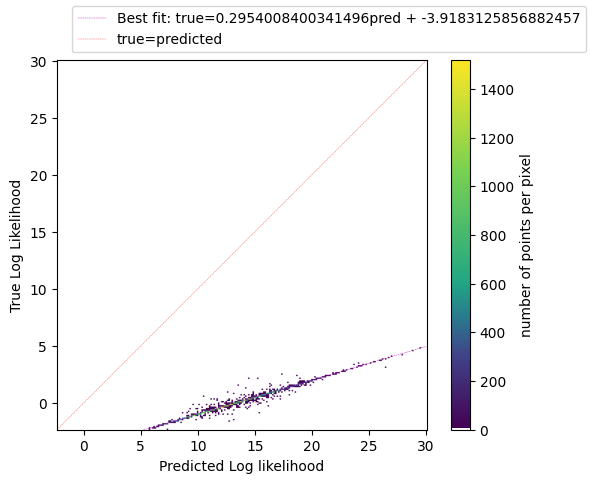

mean: -13.264392156892503, std dev: 2.3630742536647333
=====


Testing Results!
[12.25331715 12.50975461  6.02831956 ... 16.69130161 16.54353682
 14.07405967]
Mean Absolute Error : 13.23815510143664
Line of best fit : y=0.29423081581879257x + -3.8983813438890977
Saving QQ to .pdf


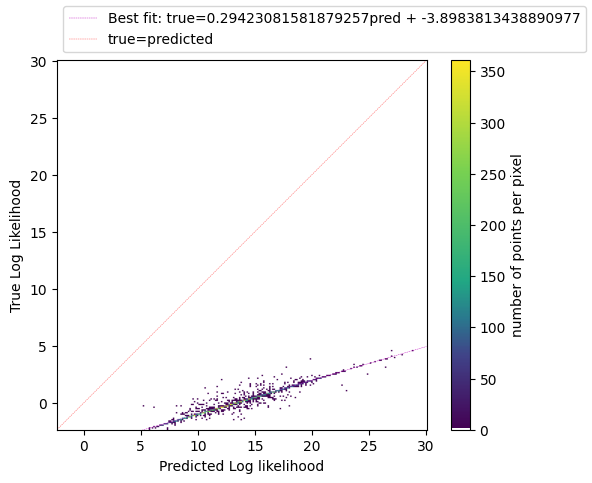

mean: -13.23815510143664, std dev: 2.361082992619628
=====




AttributeError: 'HistGradientBoostingRegressor' object has no attribute 'layers'

In [ ]:
# Now we need to test
ml_model.test_model()


In [ ]:
# Now we can save it
ml_model.save_model(f"{model_output}.keras")


# We need to save the scaling information
ml_model.save_scaler(str(model_output.parent.joinpath(Path("my_scaler.pkl"))))
print("Model saved to: ", model_output)
print("Scaler saved to: ", model_output.parent.joinpath(Path("my_scaler.pkl")))


Saving to ../models/my_model.keras
Model saved to:  ../models/my_model
Scaler saved to:  ../models/my_scaler.pkl
